##### This analysis is done in python primarily using the pandas library, and jupyter notebook as an interactive interpreter.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
pd.options.display.max_rows = 30

df = pd.read_csv("/Users/Hegstrom/Desktop/HCT390_assignment_ACO data file_downloaded.csv", thousands=',', na_values=['-'])
# Getting everything loaded up, and setting up the dataframe.


# Here, I'm making the savings rate into a percentage. This isn't necessary, I just like the formatting.
df['Sav_rate'] = df['Sav_rate']*100 

# All of these are from appendix A in the quality benchmark guideline PDF.
patient_caregiver_columns = ['ACO1','ACO2','ACO3','ACO4','ACO5',
                             'ACO6','ACO7','ACO34']

care_coordination_patient_safety_columns = ['ACO8', 'ACO35', 'ACO36',
                                            'ACO37', 'ACO38', 'ACO43',
                                           'ACO11', 'ACO12', 'ACO13', 'ACO44']

preventative_health_columns = ['ACO14', 'ACO15', 'ACO16', 'ACO17',
                              'ACO18', 'ACO19', 'ACO20', 'ACO42']

at_risk_depression_column = ['ACO40']

at_risk_dm_columns = ['ACO27', 'ACO41', 'DM_Comp']

at_risk_htn_column = ['ACO28']

at_risk_ischemic_vasc_column = ['ACO30']

at_risk_columns = at_risk_depression_column + at_risk_dm_columns + at_risk_htn_column + at_risk_ischemic_vasc_column

# Question #4

#### Evaluate the performance of the ACOs based on their track of choice. Do ACOs in a two-sided track (either Tracks 1+, 2 or 3) outperform ACOs in one-sided track (Track 1)? If so, along which dimensions of cost and quality do the two types of ACOs differ?

In [2]:
#Alright, let's splice a new dataframe to answer this question.
track_df = df[['Current_Track_1', 'Current_Track_2', 'Current_Track_3', 'Current_Track_1_Plus']]
track_df

,Current_Track_1,Current_Track_2,Current_Track_3,Current_Track_1_Plus
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,0,0,1,0
9,1,0,0,0


Let's test our data to make sure thing's are classified correctly.

Each row should only have one track, indicated by a boolean variable, which means each row should sum to 1. If it sums to 0, or >1, something is wrong.

In [3]:
# This adds the columns up across each row.
track_df.sum(axis=1)

0      1
1      1
2      1
3      1
4      1
      ..
543    1
544    1
545    1
546    1
547    1
Length: 548, dtype: int64

In [4]:
# Looks good, but ain't nobody got time to scroll through 548 rows.
# Just show me the unique values. There should only be 1.
track_df.sum(axis=1).unique()

array([1])

There are only 1's present, indicating our data is not coded incorrectly into two tracks simultaneously. We have a clean dataset. Nice! It's very convenient to not have corrupted data. Not always representative of the real world, though.

In [5]:
# Let's make our data easier to read. Note, I'm doing this is the original dataframe, not the newly spliced one.
# This means I'll need to bring in the new column.
track_classification = {
    0: 'Two Sided Track',
    1: 'One Sided Track'
}

df['Organization Track'] = df['Current_Track_1'].map(track_classification)
df['Organization Track']

0      One Sided Track
1      One Sided Track
2      One Sided Track
3      Two Sided Track
4      One Sided Track
            ...       
543    One Sided Track
544    Two Sided Track
545    One Sided Track
546    One Sided Track
547    One Sided Track
Name: Organization Track, Length: 548, dtype: object

In [6]:
track_df = df[['Sav_rate', 'Organization Track']]
track_df

,Sav_rate,Organization Track
0,5.616420,One Sided Track
1,1.443776,One Sided Track
2,-2.413121,One Sided Track
3,1.842536,Two Sided Track
4,1.606157,One Sided Track
5,3.808819,One Sided Track
6,-3.018397,One Sided Track
7,-1.907360,One Sided Track
8,3.912506,Two Sided Track
9,-3.103871,One Sided Track


In [7]:
track_savings_pivot = track_df.groupby('Organization Track').agg({'Sav_rate': [np.min, np.mean, np.max, np.median, len]})
track_savings_pivot.columns = ['Min', 'Mean', 'Max', 'Median', 'Count']
track_savings_pivot

,Min,Mean,Max,Median,Count
Organization Track,,,,,
One Sided Track,-13.331374,1.393434,31.094562,1.290393,453.0
Two Sided Track,-4.499518,2.388929,10.583065,1.884629,95.0


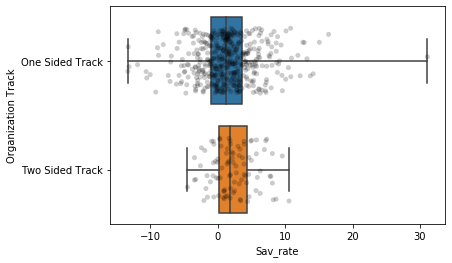

In [8]:
ax = sns.boxplot(x=track_df['Sav_rate'], y=track_df['Organization Track'], whis=np.inf)
ax = sns.stripplot(x=track_df['Sav_rate'], y=track_df['Organization Track'], color="0", jitter=.3, alpha=0.2)

There again appears to be a lot of similarity between the tracks. Though, we again have the outlier problem...

In [9]:
#Dropping the outlier.
track_df = track_df[track_df['Sav_rate'] < 30]

#Pivoting, again.
track_savings_pivot = track_df.groupby('Organization Track').agg({'Sav_rate': [np.min, np.mean, np.max, np.median, len]})
track_savings_pivot.columns = ['Min', 'Mean', 'Max', 'Median', 'Count']
track_savings_pivot

,Min,Mean,Max,Median,Count
Organization Track,,,,,
One Sided Track,-13.331374,1.327724,16.443580,1.283043,452.0
Two Sided Track,-4.499518,2.388929,10.583065,1.884629,95.0


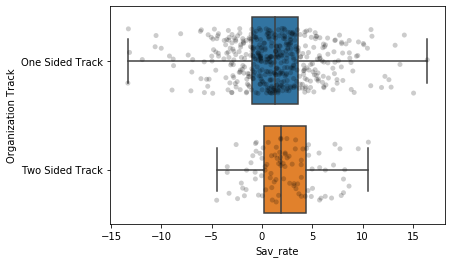

In [10]:
ax = sns.boxplot(x=track_df['Sav_rate'], y=track_df['Organization Track'], whis=np.inf)
ax = sns.stripplot(x=track_df['Sav_rate'], y=track_df['Organization Track'], color="0", jitter=.3, alpha=0.2)

Okay, so there are certainly a lot more one sided tracks than there are two sided. The average savings rate appears larger for two sided tracks. There's also a lot less variablilty. Less run a t-test.

In [15]:
from scipy import stats

#In order to do a T-Test, we need to split the groups into two seperate arrays, and pass it to another function.
one_sided = track_df[track_df['Organization Track'] == "One Sided Track"]['Sav_rate'].values
two_sided = track_df[track_df['Organization Track'] == "Two Sided Track"]['Sav_rate'].values
t, p = stats.ttest_ind(one_sided, two_sided)
print('T-Score: {}'.format(t))
print('p-value: {}'.format(p))

T-Score: -2.2598665853279347
p-value: 0.024223483439853345


The p-value is significant. So there is a statistically significant difference in the savings rate

Let's look at quality.

In [16]:
# We'll start by looking at the patient / caregiver metrics.
#The code to do this analysis is nearly identical to question 3.

patient_caregiver_df = df[['Organization Track'] + patient_caregiver_columns]
patient_caregiver_df.groupby('Organization Track').agg([np.mean, np.std, np.median]).T

Organization Track  One Sided Track  Two Sided Track
ACO1  mean                86.269073        86.079263
      std                  3.294796         3.310506
      median              86.900000        86.350000
ACO2  mean                93.757395        93.845368
      std                  1.688045         1.360550
      median              94.020000        93.900000
ACO3  mean                92.231391        92.477789
      std                  1.688186         1.609321
      median              92.420000        92.520000
ACO4  mean                81.904150        81.744632
      std                  2.812392         2.848609
      median              82.040000        82.020000
ACO5  mean                58.768675        60.038316
      std                  4.271934         4.654143
      median              58.720000        60.470000
ACO6  mean                61.900486        61.945368
      std                  3.749666         3.720832
      median              61.890000        61.710000
ACO7  mean                72.950199        73.122526
      std                  2.471466         2.350490
      median              73.190000        73.350000
ACO34 mean                26.991501        26.812211
      std                  4.416637         4.449996
      median              27.170000        26.520000

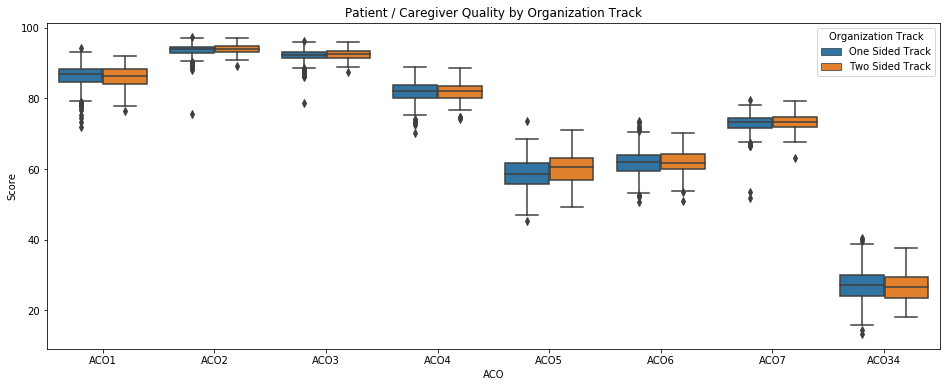

In [17]:
patient_caregiver_df = patient_caregiver_df.set_index('Organization Track').unstack()
patient_caregiver_df = patient_caregiver_df.reset_index()
patient_caregiver_df.columns = ['ACO', 'Organization Track', 'Score']
plt.figure(figsize=(16, 6))
plt.title('Patient / Caregiver Quality by Organization Track')
ax = sns.boxplot(y="Score", x='ACO', hue="Organization Track",
                 data=patient_caregiver_df, orient='v')

In [18]:
care_coordination_patient_safety_df = df[['Organization Track'] + care_coordination_patient_safety_columns]
care_coordination_patient_safety_df.groupby('Organization Track').agg([np.mean, np.std, np.median]).T

Organization Track  One Sided Track  Two Sided Track
ACO8  mean                14.964989        15.028737
      std                  0.484473         0.521716
      median              14.940000        15.190000
ACO35 mean                18.540795        18.822000
      std                  1.047796         1.092729
      median              18.490000        18.800000
ACO36 mean                37.247483        36.097474
      std                  5.028284         4.310742
      median              36.920000        35.970000
ACO37 mean                76.797550        76.657263
      std                  9.786044         8.680698
      median              76.280000        76.730000
ACO38 mean                59.093068        58.833368
      std                  7.167790         6.380782
      median              58.930000        59.120000
ACO43 mean                 2.003907         1.869579
      std                  0.388836         0.309361
      median               1.970000         1.830000
ACO11 mean                98.328057        97.474000
      std                  3.969694         4.314352
      median              99.880000        99.020000
ACO12 mean                85.685124        87.344839
      std                 16.797467        15.640858
      median              92.640000        93.640000
ACO13 mean                78.783473        83.811170
      std                 15.305660        13.677122
      median              82.480000        86.510000
ACO44 mean                64.503819        63.692947
      std                 13.251468        15.205649
      median              65.000000        65.450000

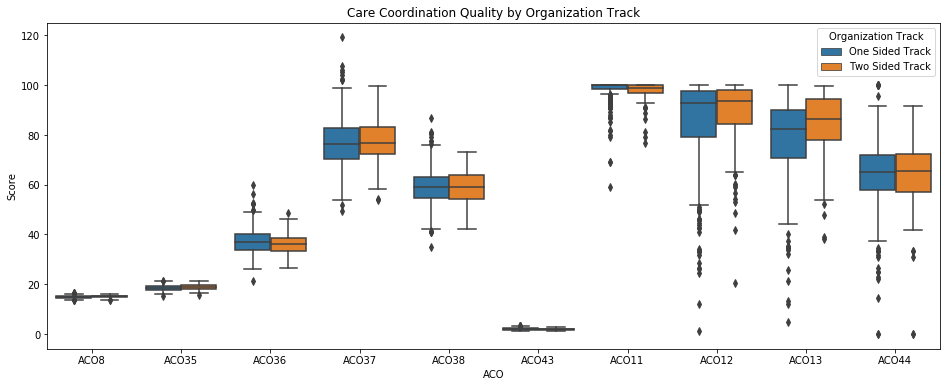

In [19]:
care_coordination_patient_safety_df = care_coordination_patient_safety_df.set_index('Organization Track').unstack()
care_coordination_patient_safety_df = care_coordination_patient_safety_df.reset_index()
care_coordination_patient_safety_df.columns = ['ACO', 'Organization Track', 'Score']
plt.figure(figsize=(16, 6))
plt.title('Care Coordination Quality by Organization Track')
ax = sns.boxplot(y="Score", x='ACO', hue="Organization Track",
                 data=care_coordination_patient_safety_df, orient='v')

In [20]:
preventative_health_df = df[['Organization Track'] + preventative_health_columns]
preventative_health_df.groupby('Organization Track').agg([np.mean, np.std, np.median]).T

Organization Track  One Sided Track  Two Sided Track
ACO14 mean                72.218075        74.897979
      std                 11.753306        13.634826
      median              72.140000        77.030000
ACO15 mean                75.155332        79.498298
      std                 12.703057        13.773871
      median              77.815000        83.485000
ACO16 mean                76.034159        80.100000
      std                 14.378252        13.351791
      median              77.495000        82.590000
ACO17 mean                72.719978        73.394149
      std                 18.775665        19.500686
      median              76.470000        76.555000
ACO18 mean                66.127898        68.897340
      std                 17.826453        18.573779
      median              68.055000        74.420000
ACO19 mean                67.439268        71.919468
      std                 11.772462        12.056792
      median              69.260000        73.925000
ACO20 mean                71.198714        75.480532
      std                 10.466523         8.918214
      median              72.280000        76.285000
ACO42 mean                81.364071        81.950213
      std                  6.939359         6.899376
      median              82.210000        82.565000

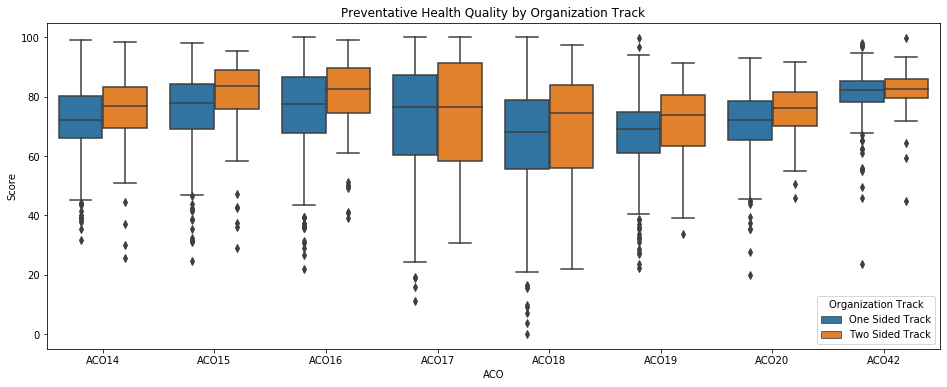

In [21]:
preventative_health_df = preventative_health_df.set_index('Organization Track').unstack()
preventative_health_df = preventative_health_df.reset_index()
preventative_health_df.columns = ['ACO', 'Organization Track', 'Score']
plt.figure(figsize=(16, 6))
plt.title('Preventative Health Quality by Organization Track')
ax = sns.boxplot(y="Score", x='ACO', hue="Organization Track",
                 data=preventative_health_df, orient='v')

In [22]:
at_risk_df = df[['Organization Track'] + at_risk_columns]
at_risk_df.groupby('Organization Track').agg([np.mean, np.std, np.median]).T

Organization Track  One Sided Track  Two Sided Track
ACO40   mean               8.642049         9.715934
        std               10.732128        11.636838
        median             6.150000         7.500000
ACO27   mean              15.875664        13.791383
        std                7.241971         4.791672
        median            14.715000        12.785000
ACO41   mean              51.532013        56.469574
        std               15.057023        15.438565
        median            51.565000        59.325000
DM_Comp mean              45.899867        50.889043
        std               14.315742        14.845904
        median            45.725000        53.615000
ACO28   mean              72.706933        75.083830
        std                7.497516         7.003141
        median            72.630000        74.665000
ACO30   mean              88.714004        89.784681
        std                7.857028         6.191245
        median            90.635000        91.080000

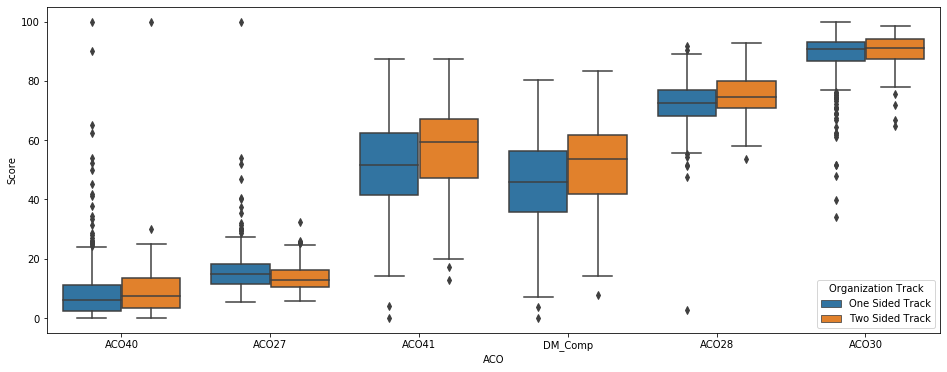

In [23]:
at_risk_df = at_risk_df.set_index('Organization Track').unstack()
at_risk_df = at_risk_df.reset_index()
at_risk_df.columns = ['ACO', 'Organization Track', 'Score']
plt.figure(figsize=(16, 6))
ax = sns.boxplot(y="Score", x='ACO', hue="Organization Track",
                 data=at_risk_df, orient='v')

Hokay, that is a lot of graphs. There's a lot of individual outcomes. If one were to perform a t-test on every single metric, there are a number that would come back significant. Sometimes being a two-sided organization is better (ACO41), sometimes it is worse (ACO27).